## Single NaKL Model for Testing Data Assimilation (February 1, 2023)

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import scipy
import scipy.integrate
import sys
sys.path.append("./data_to_figure_code")
sys.path.append("./making_stimulus_protocols")
import data_loader
import externally_provided_currents as epc

In [7]:
def S0(V,V0,dV0):
    return 0.5*(1.0+np.tanh((V-V0)/dV0))
def tau(V,t0,t1,A,B):
    return t0+t1*(1.0-(np.tanh((V-A)/B))**2)
def g(V,A,B):
    return 0.5*(1.0+np.tanh((V-A)/B))

In [26]:
# Constants
# capacitance (units: nF)
C = 1.0

# conductances and ion channel reversal potentials
gN = 120.0
vNa = 50.0
gK = 36.0#20.0
vK = -77.0
gL = 0.3
vL = -54.4

# n gating variable constants
vn = -55.0 # inflection voltage for n gating variable
dvn = 30.0
tn0 = 1.0
tn1 = 5.0

# m gating variable constants
vm = -40.0 # inflection voltage for m gating variable
dvm = 15.0
tm0 = 0.1
tm1 = 0.4

# h gating variable constants
vh = -60.0 # inflection voltage for h gating variable
dvh = -15.0
th0 = 1.0
th1 = 7.0

In [27]:
def dfdt(state, t, params):
    I = params["I"]
    I_amplitude_scaling = params["I_amplitude_scaling"]
    I_DC = params["I_DC"]
    V, m, h, n = state
    dVdt = gN*m**3*h*(vNa-V) + gK*n**4*(vK-V) + gL*(vL-V) + 0*(I_amplitude_scaling)*I(t)[0] + I_DC
    dmdt = (g(V,vm,dvm) - m)/tau(V,tm0,tm1,vm,dvm)
    dhdt = (g(V,vh,dvh) - h)/tau(V,th0,th1,vh,dvh)
    dndt = (g(V,vn,dvn) - n)/tau(V,tn0,tn1,vn,dvn)
    return [dVdt, dmdt, dhdt, dndt]

Sol is shape:(5000, 4)


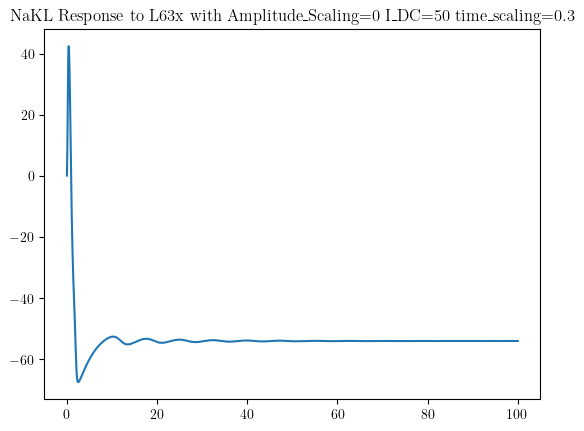

Sol is shape:(5000, 4)


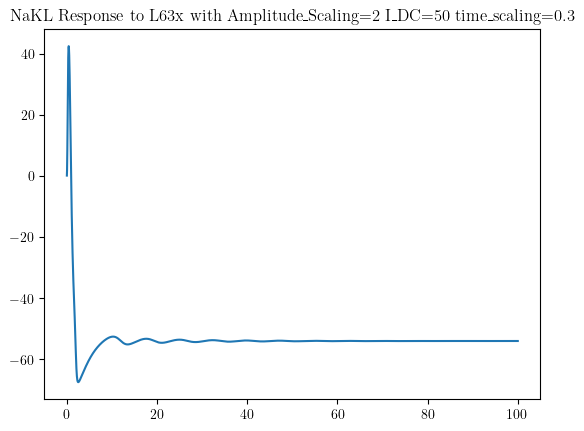

Sol is shape:(5000, 4)


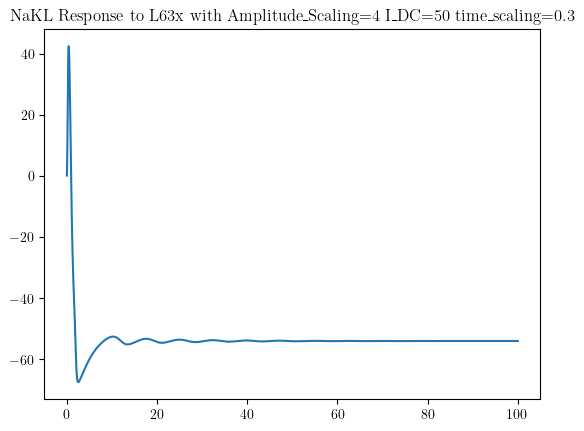

Sol is shape:(5000, 4)


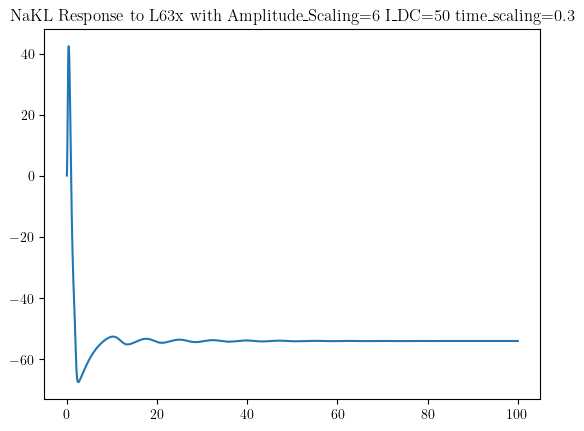

Sol is shape:(5000, 4)


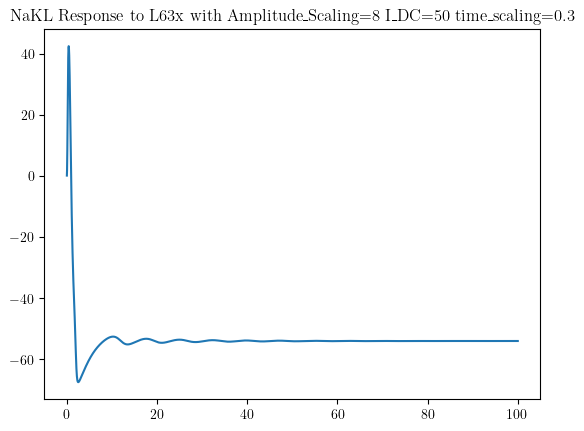

Sol is shape:(5000, 4)


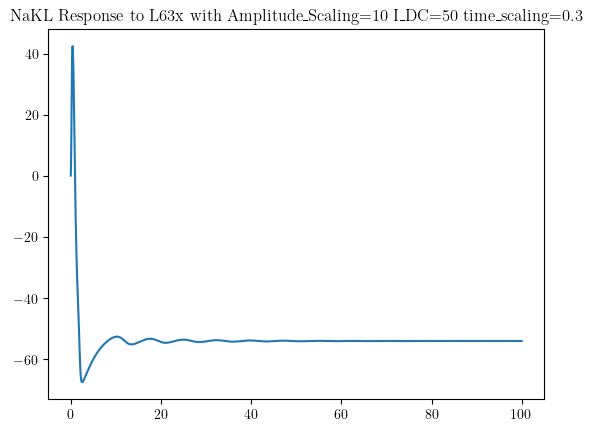

Sol is shape:(5000, 4)


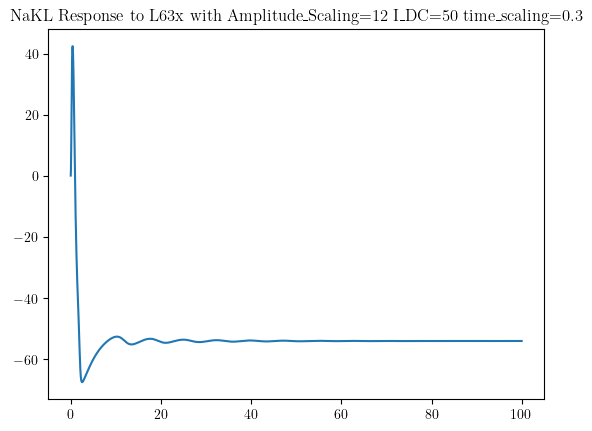

Sol is shape:(5000, 4)


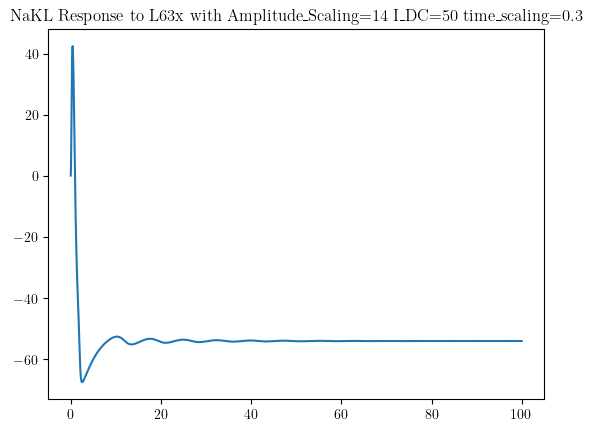

Sol is shape:(5000, 4)


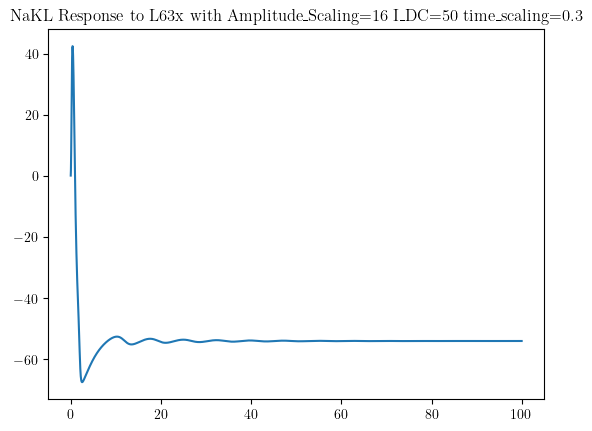

Sol is shape:(5000, 4)


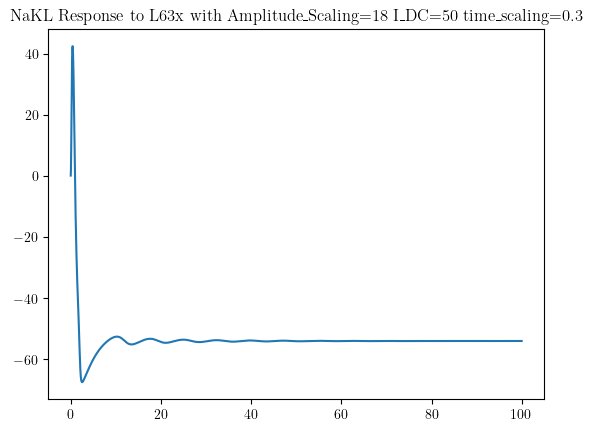

In [31]:
t_start = 0.0
t_stop = 100.0
dt = 0.02 #ms

times_array = np.arange(start=t_start,stop=t_stop, step=dt)
times_array_widened = np.arange(start=t_start-3000,stop=t_stop+3000, step=dt)

for I_amplitude_scaling in np.arange(0,20,step=2):

    I_scaling_time_factor = 0.3
    I_DC = 60

    L63_obj = epc.L63_object(scaling_time_factor=I_scaling_time_factor)
    L63_obj.prepare_f(times_array_widened)
    L63_obj.function(N=3, t=times_array)


    # I = 40*np.sin(range(times_array_widened.shape[0]))
    # I_interp = scipy.interpolate.interp1d(times_array_widened, I)

    I_interp = L63_obj.interp_function
    params = {"I":I_interp,"I_amplitude_scaling":I_amplitude_scaling, "I_DC":I_DC}

    state_initial = 0.1*np.ones((4))

    sol = scipy.integrate.odeint(dfdt, state_initial, times_array, args=(params,))
    print(f"Sol is shape:{sol.shape}")
    plt.figure()
    plt.plot(times_array, sol[:,0])
    plt.title(f"NaKL Response to L63x with Amplitude\_Scaling={I_amplitude_scaling} I\_DC={I_DC} time\_scaling={I_scaling_time_factor}")
    plt.show()

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

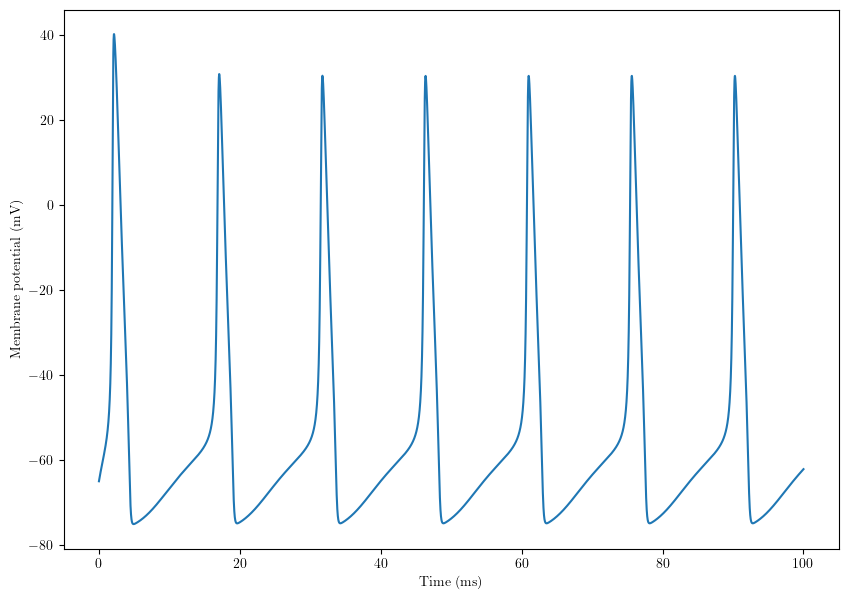

In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Constants
Cm = 1.0  # membrane capacitance (uF/cm^2)
g_Na = 120.0  # max sodium conductance (mS/cm^2)
g_K = 36.0  # max potassium conductance (mS/cm^2)
g_L = 0.3  # leak conductance (mS/cm^2)
E_Na = 50.0  # sodium reversal potential (mV)
E_K = -77.0  # potassium reversal potential (mV)
E_L = -54.387  # leak reversal potential (mV)

# External current
I_ext = 10.0  # DC current forcing (uA/cm^2)

# Initial conditions
V_0 = -65.0  # initial membrane potential (mV)
m_0 = 0.0529
h_0 = 0.5961
n_0 = 0.3177

# Voltage-gated ion channel activation and inactivation functions
def alpha_m(V):
    return (0.1 * (V + 40)) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return (0.01 * (V + 55)) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# System of ODEs
def hodgkin_huxley(y, t):
    V, m, h, n = y
    dVdt = (I_ext - (g_Na * m**3 * h * (V - E_Na) + g_K * n**4 * (V - E_K) + g_L * (V - E_L))) / Cm
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

# Time vector
t = np.linspace(0, 100, 10000)

# Initial conditions vector
y0 = [V_0, m_0, h_0, n_0]

# Solve the system of ODEs
sol = odeint(hodgkin_huxley, y0, t)

# Plot the results
plt.figure(figsize=(10, 7))
plt.plot(t, sol[:, 0], label='V (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title